In [21]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, mean_squared_error
import pickle

from daily_stock_price import get_stock_prices
from supervised_data_prep import pre_process_data, feature_selection
from supervised_modeling import model_comparison

<b>NOTES</b>
This notebook does a failure analysis on the SVR model trained in the Supervised Portion of the project. The test set is used for the analysis, and utilized data from May31, 2021 to December 31, 2021. 

Inputs:
<br>1. "Support Vector (SVR) Model.sav" - trained model to be analyzed
<br>2. "community_output_gme_test.csv" - test data for community clusters
<br>3. "df_test.csv" - test data for LDA topics
<br>4. Chosen features from model training (copy and pasted by hand - see below)
<br><br>
Outputs: None

### Load SVR Model

In [4]:
with open('Support Vector (SVR) Model.sav', 'rb') as f:
    svr = pickle.load(f)

In [5]:
print(type(svr))

<class 'sklearn.pipeline.Pipeline'>


In [6]:
for item in svr:
    display(item)

StandardScaler()

SVR(C=0.1, gamma=0.1)

### Load Test Sets, Combine and Manipulate for Model

#### Load relevant dataframes and combine into df_pre_processed.

In [9]:
df_topics_test = pd.read_csv('df_test.csv')
# display(df_coms_test.head(3))
# display(df_coms_test.tail(3))
# # display(df_coms_test.iloc[6000:15000])
# display(df_topics_test.head(3))
# display(df_topics_test.tail(3))

#Get dates of dataframes (should be last three months of the year)
MIN_DATE = df_topics_test['datetime'].min()[:10]
print("MIN_DATE: ", MIN_DATE)
MAX_DATE = df_coms_test['date'].max()[:10]
print("MAX_DATE: ", MAX_DATE)
df_prices = get_stock_prices('GME', start=MIN_DATE, end=MAX_DATE)

#This function combines 4 other functions: process_reddit_data, process_financial_data, combine_data, transform_data
df_pre_processed = pre_process_data(df_prices, 
                                    df_coms_test, 
                                    df_topics_test, 
                                    MIN_DATE, 
                                    MAX_DATE, 
                                    "GME", 
                                    shift=1, 
                                    rolling_avg=0, 
                                    stock_price='log')

len(df_pre_processed.columns)

MIN_DATE:  2021-05-31
MAX_DATE:  2021-12-31


80

The cell below was used to explore the data a little bit and to determine which feature groups are not present in the test sets. These missing features are instilled into the final processed test dataframe, as can be seen in the following cells. 

In [10]:
display(df_coms_test["community_label_str"].unique())
display(pd.read_csv('../koigawa_milestone_II/community_output_gme_train.csv')["community_label_str"].unique())
display(pd.read_csv('df_test.csv')['topic'].unique())
display(pd.read_csv('df_train.csv')['topic'].unique())
feats = ['Scriptophobic community talking about Meme & Photo Posts', 'Core, influential Redditors community talking about MOD (moderator) Announcements', 'Unpopular community talking about Brokerage Accounts_shift1', 'Scriptophobic community talking about The GME Short Squeeze', "Unpopular community talking about Unity Amoung 'Apes'_shift1", 'Unpopular community talking about Unclear Topic - Some posts about holding, FINRA, and a lot of external links_shift1', 'Unpopular community talking about MOD (moderator) Announcements', 'Scriptophobic community talking about Gamestop as a Business/Store_shift1', 'MOD (moderator) Announcements', 'Unpopular community talking about Regulatory Matters (Direct and Indirect)']
for feat in feats:
    label = "MISSING"
    if feat in list(df_pre_processed.columns):
        label = ""
    print(feat, " - ", label)

array(['Highly controversial', 'Core, influential Redditors', 'Unpopular'],
      dtype=object)

array(['Highly controversial', 'Unpopular', 'Core, influential Redditors',
       'Scriptophobic'], dtype=object)

array(['Gamestop as a Business/Store', "Unity Amoung 'Apes'",
       'Regulatory Matters (Direct and Indirect)',
       'The GME Short Squeeze', 'Brokerage Accounts',
       'General Posts/Knowledge About Understanding Stocks',
       'Meme & Photo Posts', 'MOD (moderator) Announcements',
       'Unclear Topic - Some posts about holding, FINRA, and a lot of external links',
       'Mix - GME Price Movements and Nonsense Posts'], dtype=object)

array(['The GME Short Squeeze',
       'Mix - GME Price Movements and Nonsense Posts',
       'Gamestop as a Business/Store',
       'General Posts/Knowledge About Understanding Stocks',
       'Regulatory Matters (Direct and Indirect)', "Unity Amoung 'Apes'",
       'Brokerage Accounts', 'Meme & Photo Posts',
       'MOD (moderator) Announcements',
       'Unclear Topic - Some posts about holding, FINRA, and a lot of external links'],
      dtype=object)

Scriptophobic community talking about Meme & Photo Posts  -  MISSING
Core, influential Redditors community talking about MOD (moderator) Announcements  -  
Unpopular community talking about Brokerage Accounts_shift1  -  
Scriptophobic community talking about The GME Short Squeeze  -  MISSING
Unpopular community talking about Unity Amoung 'Apes'_shift1  -  
Unpopular community talking about Unclear Topic - Some posts about holding, FINRA, and a lot of external links_shift1  -  
Unpopular community talking about MOD (moderator) Announcements  -  MISSING
Scriptophobic community talking about Gamestop as a Business/Store_shift1  -  MISSING
MOD (moderator) Announcements  -  
Unpopular community talking about Regulatory Matters (Direct and Indirect)  -  


The cell below provides the selected features used to train the model, and then creates zero vectors for any features that are missing from the processed test data. 

In [11]:
### FEATURES WERE COPY AND PASTED DIRECTLY FROM THE "model_comparison" NOTEBOOK. 
###IF A NEW MODEL IS CREATED, THIS WILL NEED TO OCCUR AGAIN.

feats = ['Scriptophobic community talking about Meme & Photo Posts', 
         'Core, influential Redditors community talking about MOD (moderator) Announcements', 
         'Unpopular community talking about Brokerage Accounts_shift1', 
         'Scriptophobic community talking about The GME Short Squeeze', 
         "Unpopular community talking about Unity Amoung 'Apes'_shift1", 
         'Unpopular community talking about Unclear Topic - Some posts about holding, FINRA, and a lot of external links_shift1', 
         'Unpopular community talking about MOD (moderator) Announcements', 
         'Scriptophobic community talking about Gamestop as a Business/Store_shift1', 
         'MOD (moderator) Announcements', 
         'Unpopular community talking about Regulatory Matters (Direct and Indirect)']

for feat in feats:
    if feat in list(df_pre_processed.columns):
        pass
    else:
        df_pre_processed[feat] = [0] * len(df_pre_processed)
        
df_pre_processed = df_pre_processed[['date', 'GME'] + feats]

#### Get Features from Train

In [12]:
df_pre_processed

,date,GME,Scriptophobic community talking about Meme & Photo Posts,"Core, influential Redditors community talking about MOD (moderator) Announcements",Unpopular community talking about Brokerage Accounts_shift1,Scriptophobic community talking about The GME Short Squeeze,Unpopular community talking about Unity Amoung 'Apes'_shift1,"Unpopular community talking about Unclear Topic - Some posts about holding, FINRA, and a lot of external links_shift1",Unpopular community talking about MOD (moderator) Announcements,Scriptophobic community talking about Gamestop as a Business/Store_shift1,MOD (moderator) Announcements,Unpopular community talking about Regulatory Matters (Direct and Indirect)
2,2021-06-02,0.125225,0,0.0,0.0,0,0.0,0.0,0,0,1.0,0.0
3,2021-06-03,-0.089101,0,0.0,0.0,0,0.0,0.0,0,0,2.0,0.0
4,2021-06-04,-0.038778,0,0.0,0.0,0,0.0,0.0,0,0,2.0,0.0
5,2021-06-05,0.000000,0,0.0,0.0,0,0.0,0.0,0,0,4.0,0.0
6,2021-06-06,0.000000,0,0.0,0.0,0,0.0,0.0,0,0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
210,2021-12-27,-0.025496,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0
211,2021-12-28,-0.012552,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0
212,2021-12-29,0.049746,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0
213,2021-12-30,0.009054,0,0.0,0.0,0,0.0,0.0,0,0,0.0,0.0


### Use Test Data to Predict Values

In [23]:
X_test = np.array(df_pre_processed.drop(['date','GME'], axis = 1))

Y_target = df_pre_processed['GME']
y_pred = svr.predict(np.array(X_test))
R2_score = svr.score(X_test, Y_target)
MSE_score = mean_squared_error(Y_target, y_pred)

C:\Users\sbmoi\Anaconda\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
C:\Users\sbmoi\Anaconda\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [24]:
Y_target

2      0.125225
3     -0.089101
4     -0.038778
5      0.000000
6      0.000000
         ...   
210   -0.025496
211   -0.012552
212    0.049746
213    0.009054
214    0.000000
Name: GME, Length: 213, dtype: float64

In [25]:
print("R2 Score: ", R2_score)
print("MSE Score: ", MSE_score)

R2 Score:  -0.6890237875863205
MSE Score:  0.003454468706598315


### Check to see which days had the largest error (absolute price difference)
Order the inputs by value, and take the 'X' number of largest differences.

Try to find patterns in the errors. 

Should have at least three examples of failure, and try to find 3 categories of failure.

Should be able to develope solutions to fix these failures. 

In [20]:
print("TARGET\n Min: ", Y_target.min(), 
      "\n Max: ", Y_target.max(), 
      "\n Mean: ", Y_target.mean(), 
      "\n Median: ", Y_target.median(), 
      "\n Std:", Y_target.std(), 
      "\n Length: ", len(Y_target))
print("PREDICTION\n Min: ", y_pred.min(), 
      "\n Max: ", y_pred.max(), 
      "\n Mean: ", y_pred.mean(), 
      "\n Median: ", pd.Series(y_pred).median(), 
      "\n Std:", y_pred.std(), 
      "\n Length: ", len(y_pred))
print("TOGETHER\n Mean:", pd.concat([Y_target, pd.Series(y_pred)]).reset_index(drop = True).mean(), 
"\n StD:", pd.concat([Y_target, pd.Series(y_pred)]).reset_index(drop = True).std())

TARGET
 Min:  -0.3168808954117992 
 Max:  0.24320891732259642 
 Mean:  -0.0022158748070112274 
 Median:  0.0 
 Std: 0.04533092901906864 
 Length:  213
PREDICTION
 Min:  -0.00989521401771366 
 Max:  0.049291099991080084 
 Mean:  0.02526809609082852 
 Median:  0.049291099991080084 
 Std: 0.027187665284722804 
 Length:  213
TOGETHER
 Mean: 0.011526110641908647 
 StD: 0.0398091663150316


### Confusion Matrix

Below a couple different confusion matrices are made (only one was chosen for the report) and the results are explored. 

In [27]:
cm_df2 = pd.DataFrame({"target": Y_target, "prediction": y_pred})
cm_df2["target"] = (1 - (np.e**(cm_df2["target"])))*100
cm_df2["prediction"] = (1 - (np.e**(cm_df2["prediction"])))*100
cm_df2['difference'] = cm_df2['prediction'] - cm_df2['target']

In [28]:
cm_df2

,target,prediction,difference
2,-13.340288,0.844828,14.185116
3,8.524659,-0.174157,-8.698816
4,3.803545,-0.174157,-3.977702
5,0.000000,-0.175094,-0.175094
6,0.000000,0.844828,0.844828
...,...,...,...
210,2.517419,-5.052611,-7.570031
211,1.247381,-5.052611,-6.299993
212,-5.100359,-5.052611,0.047747
213,-0.909510,-5.052611,-4.143101


In [30]:
print("TARGET\n Min: ", 
      cm_df2["target"].min(), 
      "\n Max: ", cm_df2["target"].max(), 
      "\n Mean: ", cm_df2["target"].mean(), 
      "\n Median: ", cm_df2["target"].median(), 
      "\n Std:", cm_df2["target"].std(), 
      "\n Length: ", len(cm_df2["target"]))
print("PREDICTION\n Min: ", 
      cm_df2["prediction"].min(), 
      "\n Max: ", cm_df2["prediction"].max(), 
      "\n Mean: ", cm_df2["prediction"].mean(), "\n Median: ", cm_df2["prediction"].median(),
      "\n Std:", cm_df2["prediction"].std(), 
      "\n Length: ", len(cm_df2["prediction"]))
print("DIFFERENCE\n Min: ", 
      cm_df2["difference"].min(), 
      "\n Max: ", cm_df2["difference"].max(), 
      "\n Mean: ", cm_df2["difference"].mean(), 
      "\n Median: ", cm_df2["difference"].median(),  
      "\n Std:", cm_df2["difference"].std(), 
      "\n Length: ", len(cm_df2["difference"]))
print("TOGETHER\n Mean:", pd.concat([cm_df2["target"], pd.Series(cm_df2["prediction"])]).reset_index(drop = True).mean(), 
"\n StD:", pd.concat([cm_df2["target"], pd.Series(cm_df2["prediction"])]).reset_index(drop = True).std())

TARGET
 Min:  -27.533503586958297 
 Max:  27.158249217341524 
 Mean:  0.12032842153657403 
 Median:  0.0 
 Std: 4.479202568937514 
 Length:  213
PREDICTION
 Min:  -5.0526114376497455 
 Max:  0.9846417470876112 
 Mean:  -2.596815413119641 
 Median:  -5.0526114376497455 
 Std: 2.784748099912956 
 Length:  213
DIFFERENCE
 Min:  -27.33240583504787 
 Max:  28.484599466436432 
 Mean:  -2.717143834656215 
 Median:  -3.8713701109870264 
 Std: 5.21859555680189 
 Length:  213
TOGETHER
 Mean: -1.2382434957915334 
 StD: 3.965649024590756


In [279]:
std = Y_target.std()
print(std)
bins = [-100, -8, -6, -4, -2, 0, 2, 4, 6, 8, 100]
target = pd.cut(cm_df2["target"], bins = bins, precision = 32)
prediction = pd.cut( cm_df2["prediction"], bins = bins, precision = 2)

labels = ['<-8%', '-6% to -8%', '-4% to -6%', '-2% to -4%', '0% to -2%', '0% to 2%', '2% to 4%', '4% to 6%', '6% to 8%', '>8%']

cm_df2['target_range'] = target.astype('string')
cm_df2['prediction_range'] = prediction.astype('string')
lab_dict = {'(-100, -8]': 0,'(8, 100]': 9,'(2, 4]': 6,'(-2, 0]': 4,'(-8, -6]': 1,
            '(-6, -4]': 2,'(0, 2]': 5,'(4, 6]': 7,'(6, 8]': 8,'(-4, -2]': 3}
cm_df2['tar'] = cm_df2['target_range'].map(lab_dict)
cm_df2['pred'] = cm_df2['prediction_range'].map(lab_dict)
    
cm_df2

#conf_mat = confusion_matrix(target, prediction, labels = labels)

0.04533092901906864


,target,prediction,difference,target_range,prediction_range,tar,pred
2,-13.340288,0.844828,14.185116,"(-100, -8]","(0, 2]",0,5
3,8.524659,-0.174157,-8.698816,"(8, 100]","(-2, 0]",9,4
4,3.803545,-0.174157,-3.977702,"(2, 4]","(-2, 0]",6,4
5,0.000000,-0.175094,-0.175094,"(-2, 0]","(-2, 0]",4,4
6,0.000000,0.844828,0.844828,"(-2, 0]","(0, 2]",4,5
...,...,...,...,...,...,...,...
210,2.517419,-5.052611,-7.570031,"(2, 4]","(-6, -4]",6,2
211,1.247381,-5.052611,-6.299993,"(0, 2]","(-6, -4]",5,2
212,-5.100359,-5.052611,0.047747,"(-6, -4]","(-6, -4]",2,2
213,-0.909510,-5.052611,-4.143101,"(-2, 0]","(-6, -4]",4,2


In [281]:
conf_mat = confusion_matrix(cm_df2['tar'], cm_df2['pred'])

In [282]:
conf_mat

array([[ 0,  0,  3,  0,  1,  4,  0,  0,  0,  0],
       [ 0,  0,  4,  0,  1,  1,  0,  0,  0,  0],
       [ 0,  0,  6,  0,  0,  2,  0,  0,  0,  0],
       [ 0,  0,  8,  0,  4,  3,  0,  0,  0,  0],
       [ 0,  0, 53,  0, 14, 29,  0,  0,  0,  0],
       [ 0,  0, 22,  0,  3,  7,  0,  0,  0,  0],
       [ 0,  0, 14,  0,  3,  9,  0,  0,  0,  0],
       [ 0,  0,  6,  0,  2,  4,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  1,  1,  0,  0,  0,  0],
       [ 0,  0,  1,  0,  3,  2,  0,  0,  0,  0]])

In [283]:
len(cm_df2[(cm_df2['tar'] == 5) & (cm_df2['pred'] == 2)])

22

Text(0.5, 1.0, 'Percent Change in GME Stock:\nTrue vs. Predicted')

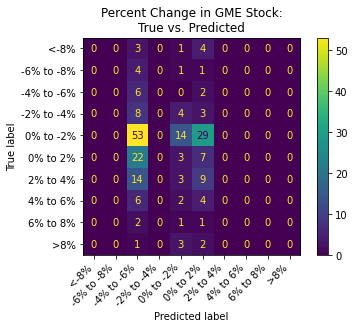

In [292]:
cm = ConfusionMatrixDisplay(conf_mat, display_labels = []).plot()
#cm.ax_.tick_params(axis='x', labelrotation=90)
cm.ax_.set_xticklabels(labels, rotation=45, ha='right')
cm.ax_.set_yticklabels(labels)
cm.ax_.set_title("Percent Change in GME Stock:\nTrue vs. Predicted")

## The results analyzed for the report start here. 

In [ ]:
# print("Days the model predicted the stock to drop and it dropped (True Negative): ")
print(len(cm_df2[(cm_df2['tar'] < 5) & (cm_df2['pred'] < 5)]))

print("\nDays the model predicted the stock to drop and it went up (False Negative): ")
print(len(cm_df2[(cm_df2['tar'] > 4) & (cm_df2['pred'] < 5)]))

print("\nDays the model predicted the stock to go up and it dropped (False Positive): ")
print(len(cm_df2[(cm_df2['tar'] < 5) & (cm_df2['pred'] > 4)]))

print("\nDays the model predicted the stock to go up and it went up (True Positive): ")
print(len(cm_df2[(cm_df2['tar'] > 4) & (cm_df2['pred'] > 4)]))

In [309]:
cm_df3 = cm_df2.copy()
std = Y_target.std()
print(std)
bins = [-100, -8, -6, -4, -2, -.000001, 0.000001, 2, 4, 6, 8, 100]
target = pd.cut(cm_df3["target"], bins = bins, precision = 32)
prediction = pd.cut( cm_df3["prediction"], bins = bins, precision = 2)

labels = ['<-8%', '-6% to -8%', '-4% to -6%', '-2% to -4%', '0% to -2%', '0%', '0% to 2%', '2% to 4%', '4% to 6%', '6% to 8%', '>8%']

cm_df3['target_range'] = target.astype('string')
cm_df3['prediction_range'] = prediction.astype('string')
lab_dict = {'(-100.0, -8.0]': 0,'(8.0, 100.0]': 10,'(2.0, 4.0]': 7,'(-2.0, -1e-06]': 4,'(-8.0, -6.0]': 1,
            '(-6.0, -4.0]': 2, '(-1e-06, 1e-06]': 5, '(1e-06, 2.0]': 6,'(4.0, 6.0]': 8,'(6.0, 8.0]': 9,'(-4.0, -2.0]': 3}
cm_df3['tar'] = cm_df3['target_range'].map(lab_dict)
cm_df3['pred'] = cm_df3['prediction_range'].map(lab_dict)
    
lab_dict

0.04533092901906864


{'(-100.0, -8.0]': 0,
 '(8.0, 100.0]': 10,
 '(2.0, 4.0]': 7,
 '(-2.0, -1e-06]': 4,
 '(-8.0, -6.0]': 1,
 '(-6.0, -4.0]': 2,
 '(-1e-06, 1e-06]': 5,
 '(1e-06, 2.0]': 6,
 '(4.0, 6.0]': 8,
 '(6.0, 8.0]': 9,
 '(-4.0, -2.0]': 3}

In [301]:
conf_mat = confusion_matrix(cm_df3['tar'], cm_df3['pred'])

Text(0.5, 1.0, 'Percent Change in GME Stock:\nTrue vs. Predicted')

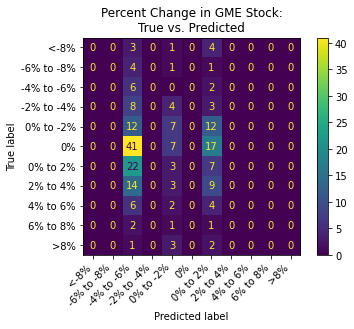

In [302]:
cm = ConfusionMatrixDisplay(conf_mat, display_labels = []).plot()
#cm.ax_.tick_params(axis='x', labelrotation=90)
cm.ax_.set_xticklabels(labels, rotation=45, ha='right')
cm.ax_.set_yticklabels(labels)
cm.ax_.set_title("Percent Change in GME Stock:\nTrue vs. Predicted")

In [310]:
print("Days the model predicted the stock to drop and it dropped (True Negative): ")
print(len(cm_df3[(cm_df3['tar'] < 5) & (cm_df3['pred'] < 5)]))

print("\nDays the model predicted the stock to drop and it went up (False Negative): ")
print(len(cm_df3[(cm_df3['tar'] > 5) & (cm_df3['pred'] < 5)]))

print("\nDays the model predicted the stock to go up and it dropped (False Positive): ")
print(len(cm_df3[(cm_df3['tar'] < 5) & (cm_df3['pred'] > 5)]))

print("\nDays the model predicted the stock to go up and it went up (True Positive): ")
print(len(cm_df3[(cm_df3['tar'] > 5) & (cm_df3['pred'] > 5)]))

print("\nDays the model predicted the stock to go up but the market was closed: ")
print(len(cm_df3[(cm_df3['tar'] == 5) & (cm_df3['pred'] > 5)]))

print("\nDays the model predicted the stock to drop but the market was closed: ")
print(len(cm_df3[(cm_df3['tar'] == 5) & (cm_df3['pred'] < 5)]))

Days the model predicted the stock to drop and it dropped (True Negative): 
46

Days the model predicted the stock to drop and it went up (False Negative): 
57

Days the model predicted the stock to go up and it dropped (False Positive): 
22

Days the model predicted the stock to go up and it went up (True Positive): 
23

Days the model predicted the stock to go up but the market was closed: 
17

Days the model predicted the stock to drop but the market was closed: 
48


In [333]:
# cm_df3[(cm_df3['tar'] == 0) & (cm_df3['pred'] > 5)])
# cm_df3[(cm_df3['tar'] == 0) & (cm_df3['pred'] > 5)])
display(cm_df3.tail())
cm_df3['ABS_diff'] = cm_df3['difference'].abs()
cm_df3.reset_index().sort_values('ABS_diff', ascending = False).head(15)

,target,prediction,difference,target_range,prediction_range,tar,pred,ABS_diff
210,2.517419,-5.052611,-7.570031,"(2.0, 4.0]","(-6.0, -4.0]",7,2,7.570031
211,1.247381,-5.052611,-6.299993,"(1e-06, 2.0]","(-6.0, -4.0]",6,2,6.299993
212,-5.100359,-5.052611,0.047747,"(-6.0, -4.0]","(-6.0, -4.0]",2,2,0.047747
213,-0.909510,-5.052611,-4.143101,"(-2.0, -1e-06]","(-6.0, -4.0]",4,2,4.143101
214,0.000000,-5.052611,-5.052611,"(-1e-06, 1e-06]","(-6.0, -4.0]",5,2,5.052611


,index,target,prediction,difference,target_range,prediction_range,tar,pred,ABS_diff
83,85,-27.533504,0.951096,28.484599,"(-100.0, -8.0]","(1e-06, 2.0]",0,6,28.484599
8,10,27.158249,-0.174157,-27.332406,"(8.0, 100.0]","(-2.0, -1e-06]",10,4,27.332406
174,176,13.593217,-5.052611,-18.645828,"(8.0, 100.0]","(-6.0, -4.0]",10,2,18.645828
0,2,-13.340288,0.844828,14.185116,"(-100.0, -8.0]","(1e-06, 2.0]",0,6,14.185116
194,196,13.917358,0.844828,-13.072530,"(8.0, 100.0]","(1e-06, 2.0]",10,6,13.072530
5,7,-12.743602,-0.175094,12.568508,"(-100.0, -8.0]","(-2.0, -1e-06]",0,4,12.568508
142,144,6.554402,-5.052611,-11.607013,"(6.0, 8.0]","(-6.0, -4.0]",9,2,11.607013
19,21,6.290343,-5.052611,-11.342955,"(6.0, 8.0]","(-6.0, -4.0]",9,2,11.342955
48,50,-10.196545,0.844828,11.041374,"(-100.0, -8.0]","(1e-06, 2.0]",0,6,11.041374
118,120,5.742025,-5.052611,-10.794637,"(4.0, 6.0]","(-6.0, -4.0]",8,2,10.794637


Below shows how sparse the matrix is. Only two fields have counts higher than 2. 

In [347]:
df_pre_processed.iloc[[83, 8, 174, 0, 194, 5]]
df_pre_processed.drop(['date', 'GME'], axis = 1).sum()

Scriptophobic community talking about Meme & Photo Posts                                                                   0.0
Core, influential Redditors community talking about MOD (moderator) Announcements                                         11.0
Unpopular community talking about Brokerage Accounts_shift1                                                                1.0
Scriptophobic community talking about The GME Short Squeeze                                                                0.0
Unpopular community talking about Unity Amoung 'Apes'_shift1                                                               2.0
Unpopular community talking about Unclear Topic - Some posts about holding, FINRA, and a lot of external links_shift1      1.0
Unpopular community talking about MOD (moderator) Announcements                                                            0.0
Scriptophobic community talking about Gamestop as a Business/Store_shift1                                      